In [198]:
# !pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
# !pip install lightning albumentations
# !pip install scikit-image

In [199]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage.filters import threshold_otsu
import torch.nn as nn

In [200]:
EPOCHS = 15
OUT_CLASSES = 1
method = "UnetPlusPlus" # FPN, Unet, UnetPlusPlus, DeepLabV3Plus
backbone = "resnet18" # resnet18, mobilenet_v2
datasrc = "UDIAT" # BUSIS, UDIAT
isTrain = False # True / False

In [201]:
def read_file_to_list(file_path):
    """
    Reads a file and returns a list where each element is a line from the file.

    Args:
        file_path (str): The path to the file.

    Returns:
        list: A list of strings, where each string is a line from the file.
              Returns an empty list if the file cannot be opened.
    """
    try:
        with open(file_path, 'r') as file:
            return file.read().splitlines()
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return []

class CustomDataset(BaseDataset):
    """Custom Dataset. Read images, apply augmentation transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)

    """

    CLASSES = [
        "tumor",
        "unlabelled",
    ]

    def __init__(
        self,
        datasrc = 'BUSIS', # BUSIS, UDIAT
        type = 'train', # 'train', 'val' 
        augmentation=None,
    ):
        images_dir = '../data/{}/imgs/'.format(datasrc)
        masks_dir = '../data/{}/gts/'.format(datasrc)

        if datasrc == 'UDIAT':
            self.ids = read_file_to_list('../data/{}/{}.txt'.format(datasrc,type))
            self.images_fps = [os.path.join(images_dir, image_id)+'.png' for image_id in self.ids]
            self.masks_fps = [os.path.join(masks_dir, image_id)+'.png' for image_id in self.ids]
        elif datasrc == 'BUSIS':
            self.ids = os.listdir(images_dir)
            list_length = len(self.ids)
            split_index = int(list_length * 0.7)  # Calculate the 70% split index
            if type == 'train':
                self.ids = self.ids[:split_index]  # Create the 70% list
            elif type == 'val':
                self.ids = self.ids[split_index:]  # Create the 30% list
            self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
            self.masks_fps = [os.path.join(masks_dir, image_id)[:-4]+'_GT.bmp' for image_id in self.ids]
        
        # convert str names to class values on masks
        classes=["tumor"]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation

    def __getitem__(self, i):
        # print(self.images_fps[i])
        # print(self.masks_fps[i])
        image = cv2.imread(self.images_fps[i])
        # BGR-->RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # print(np.shape(mask))
        # extract certain classes from mask (e.g. cars)
        masks = [(mask != v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image.transpose(2, 0, 1), mask.transpose(2, 0, 1)

    def __len__(self):
        return len(self.ids)

In [202]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()

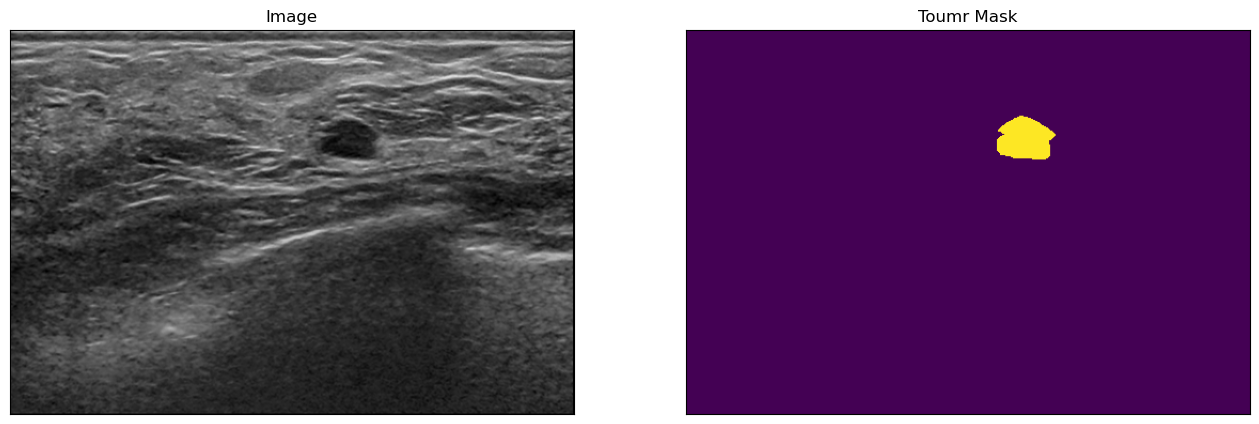

In [203]:
dataset = CustomDataset(datasrc, type='train')
# get some sample
image, mask = dataset[0]
visualize(
    image=image,
    toumr_mask=mask.squeeze(),
)

In [204]:
def get_training_augmentation():
    train_transform = [
        # albu.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.2),
        A.Resize(height=512, width=512, always_apply=True),
        # albu.OneOf(
        #     [
        #         albu.CLAHE(p=1),
        #         albu.RandomBrightnessContrast(
        #             brightness_limit=0.2, contrast_limit=0, p=1
        #         ),
        #         albu.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(
                    brightness_limit=0, contrast_limit=0.2, p=1
                ),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    # albu.PadIfNeeded(384, 480)
    test_transform = [A.Resize(height=512, width=512, always_apply=True)]
    return A.Compose(test_transform)

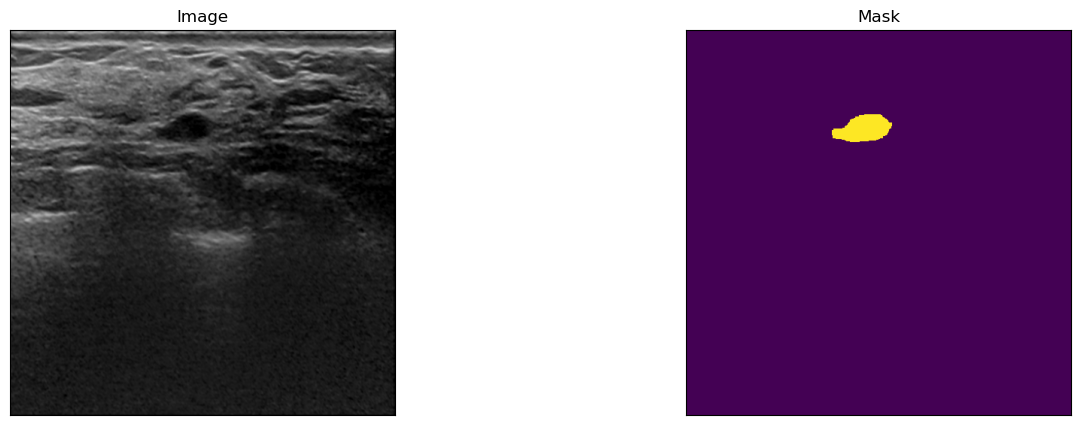

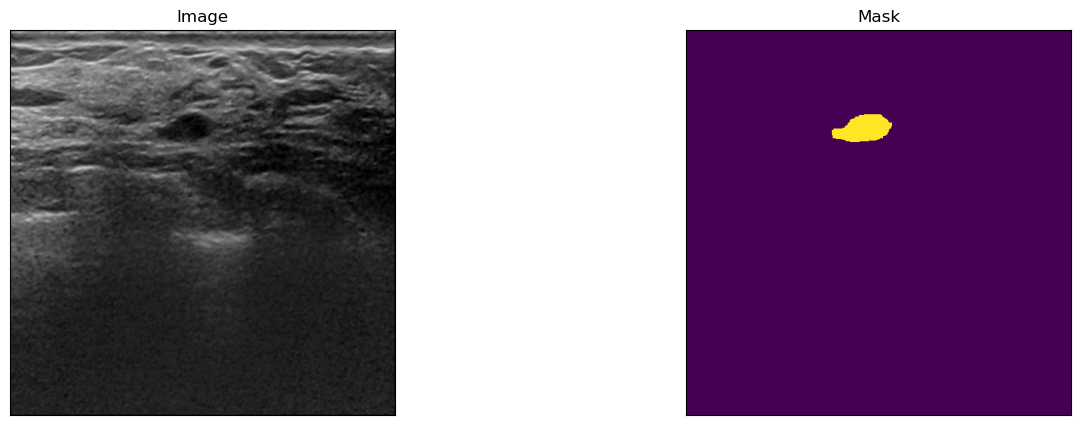

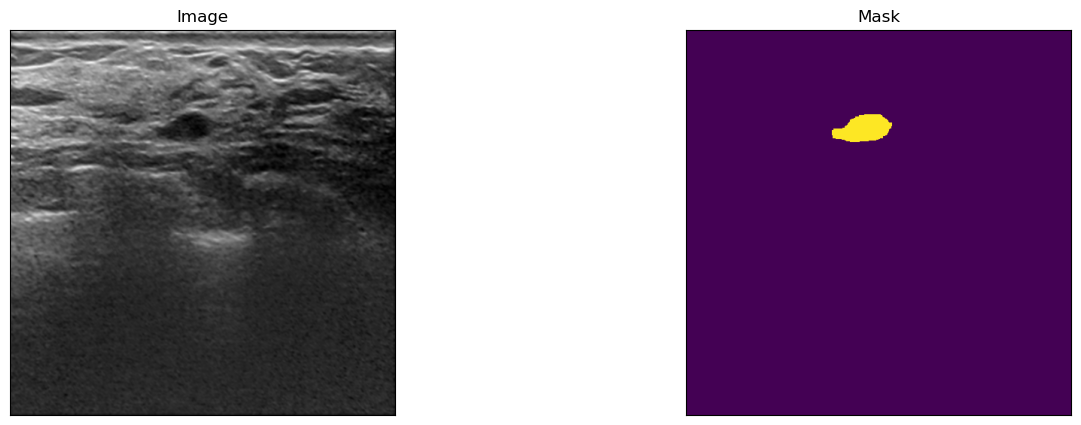

In [205]:
# Visualize resulted augmented images and masks
augmented_dataset = CustomDataset(
    datasrc, type='train',
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze())

In [206]:
CLASSES = ["tumor"]

train_dataset = CustomDataset(
    datasrc, type='train',
    augmentation=get_training_augmentation(),
)

valid_dataset = CustomDataset(
    datasrc, type='val',
    augmentation=get_validation_augmentation(),
)
print(f"Number of samples in train subset: {len(train_dataset)}")
print(f"Number of samples in valid subset: {len(valid_dataset)}")
# n_cpu = os.cpu_count()
n_cpu = 0
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=n_cpu)
valid_loader = DataLoader(valid_dataset, batch_size=40, shuffle=False, num_workers=n_cpu)

Number of samples in train subset: 114
Number of samples in valid subset: 49


## Model

In [207]:
def convert_bn_to_gn(module, max_groups=32):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features

            # Find the largest group number ≤ max_groups that divides num_channels
            for g in reversed(range(1, max_groups + 1)):
                if num_channels % g == 0:
                    num_groups = g
                    break

            gn = nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)
            setattr(module, name, gn)
        else:
            convert_bn_to_gn(child, max_groups=max_groups)

In [ ]:
class CustomModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )


        # REPLACE all BatchNorm2d layers with GroupNorm for DeepLabV3Plus
        if arch == "DeepLabV3Plus":
            convert_bn_to_gn(self.model)
        
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])


        metrics = {}
        lst_red = ["micro", "macro", "micro-imagewise", "macro-imagewise"]

        for itm_red in lst_red:
            metrics.update({
                f"{stage}_{itm_red}_iou": smp.metrics.iou_score(tp, fp, fn, tn, reduction=itm_red),
                f"{stage}_{itm_red}_f1_score": smp.metrics.f1_score(tp, fp, fn, tn, reduction=itm_red),
                f"{stage}_{itm_red}_precision": smp.metrics.precision(tp, fp, fn, tn, reduction=itm_red),
                f"{stage}_{itm_red}_recall": smp.metrics.recall(tp, fp, fn, tn, reduction=itm_red),
                f"{stage}_{itm_red}_sensitivity": smp.metrics.sensitivity(tp, fp, fn, tn, reduction=itm_red),
                f"{stage}_{itm_red}_specificity": smp.metrics.specificity(tp, fp, fn, tn, reduction=itm_red),
            })

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader), eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [210]:
model = CustomModel(method, backbone, in_channels=3, out_classes=OUT_CLASSES)

## Training

In [211]:
if isTrain:
    trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1,accelerator='cpu')
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=valid_loader,
    )

In [212]:
model_path = '../models/weights__{}__{}__{}.pth'.format(method, backbone, datasrc)
print(model_path)
if isTrain: 
    torch.save(model.state_dict(), model_path)

../models/weights__UnetPlusPlus__resnet18__UDIAT.pth


# Result visualization

In [213]:
model2 = CustomModel(method, backbone, in_channels=3, out_classes=OUT_CLASSES)
model2.load_state_dict(torch.load(model_path))
model2.eval()

/var/folders/vd/h_c9pfgj51nctb1fk79c95rr0000gn/T/ipykernel_31807/1061494959.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(model_path)

CustomModel(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b

In [214]:
# run validation dataset
if isTrain:
    valid_metrics = trainer.validate(model2, dataloaders=valid_loader, verbose=False)
    print(valid_metrics)

0
Prediction mask was not binary. Applied Otsu threshold: 0.4926590025424957


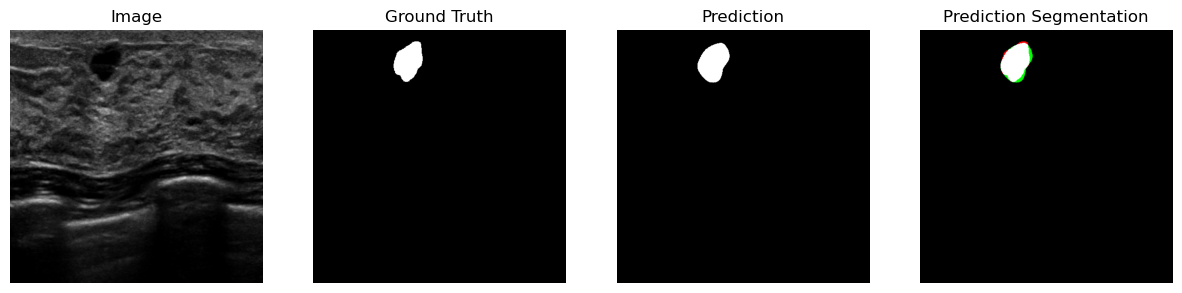

1
Prediction mask was not binary. Applied Otsu threshold: 0.4931653141975403


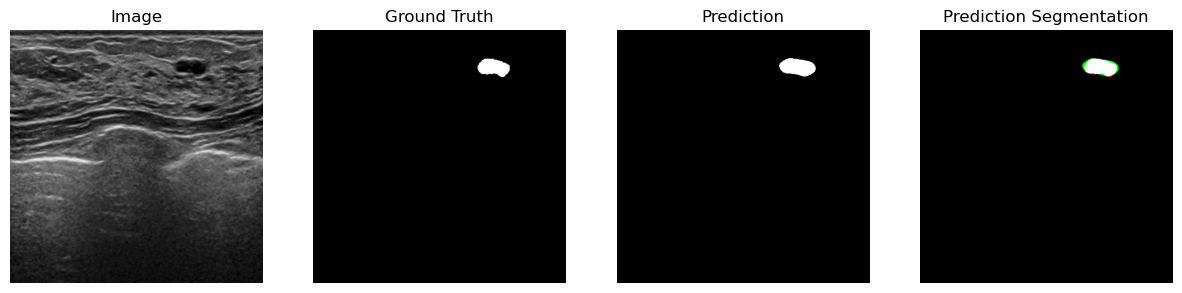

2
Prediction mask was not binary. Applied Otsu threshold: 0.4890717566013336


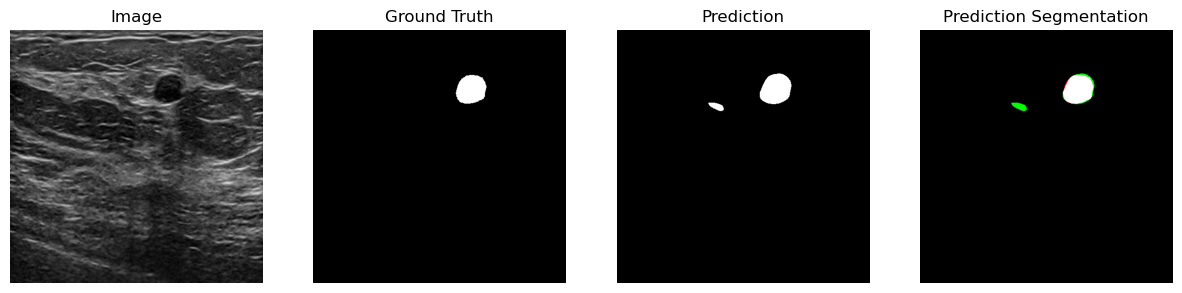

3
Prediction mask was not binary. Applied Otsu threshold: 0.4994245171546936


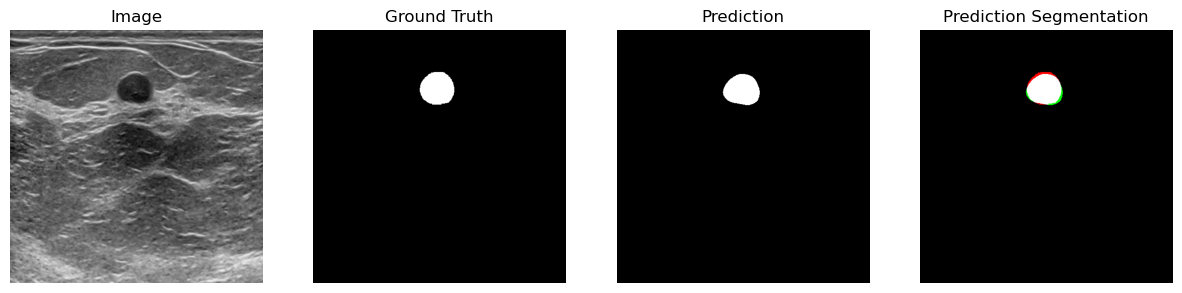

4
Prediction mask was not binary. Applied Otsu threshold: 0.49673956632614136


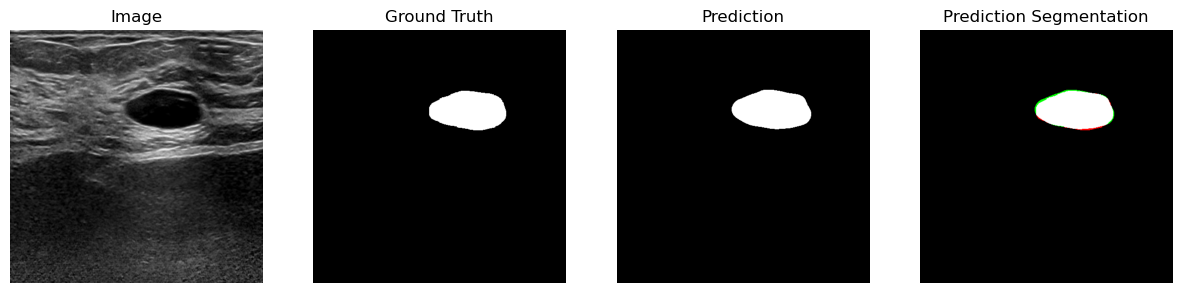

5
Prediction mask was not binary. Applied Otsu threshold: 0.4966813325881958


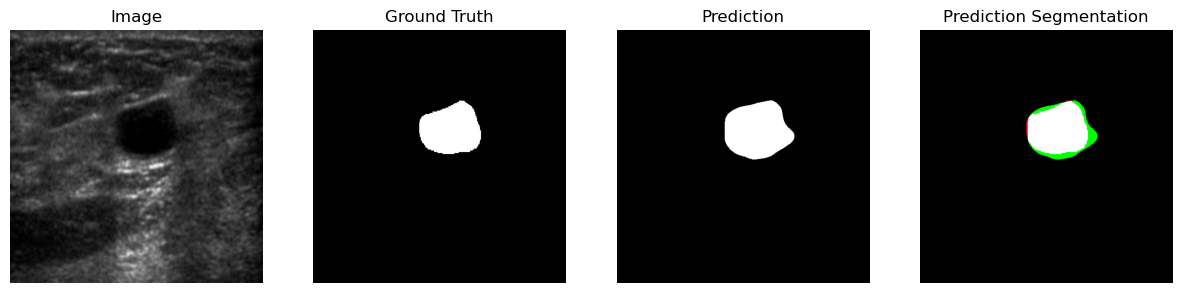

6
Prediction mask was not binary. Applied Otsu threshold: 0.5009011030197144


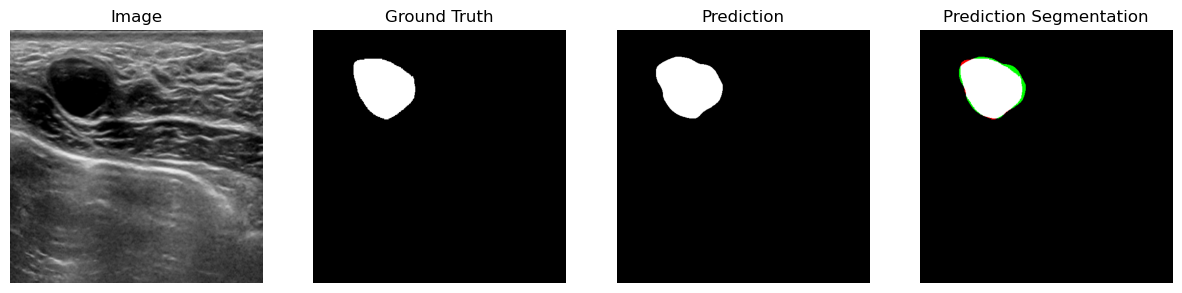

7
Prediction mask was not binary. Applied Otsu threshold: 0.5003461241722107


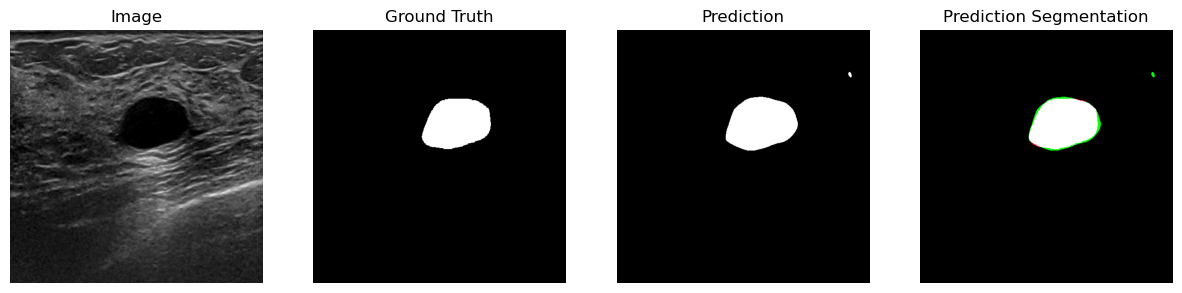

8
Prediction mask was not binary. Applied Otsu threshold: 0.4593265652656555


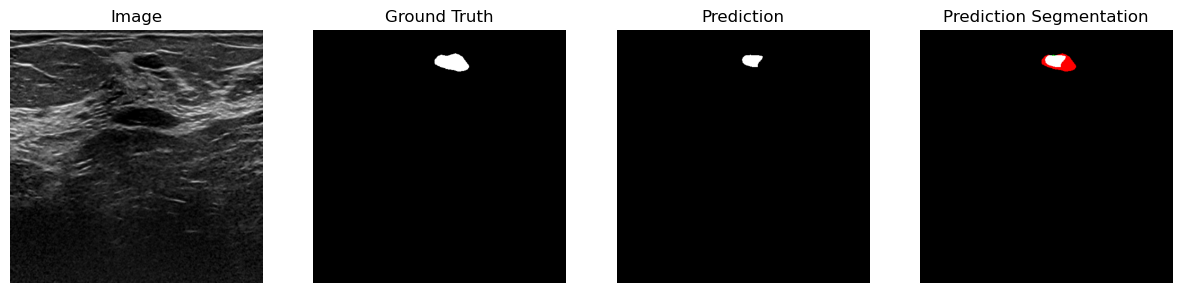

9
Prediction mask was not binary. Applied Otsu threshold: 0.48896706104278564


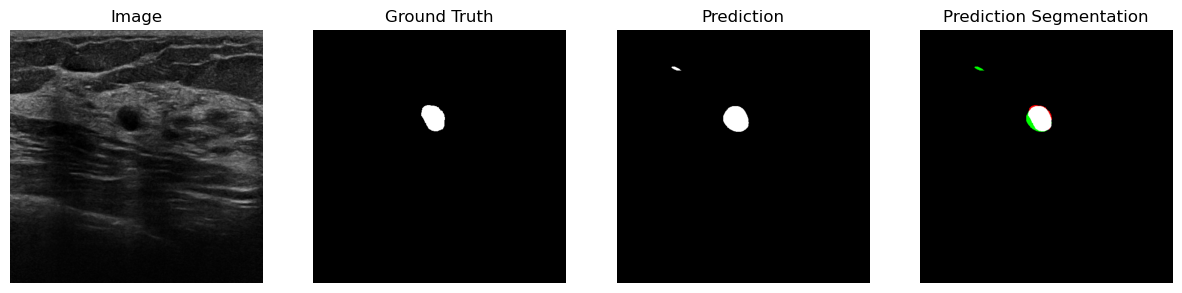

10
Prediction mask was not binary. Applied Otsu threshold: 0.49673992395401


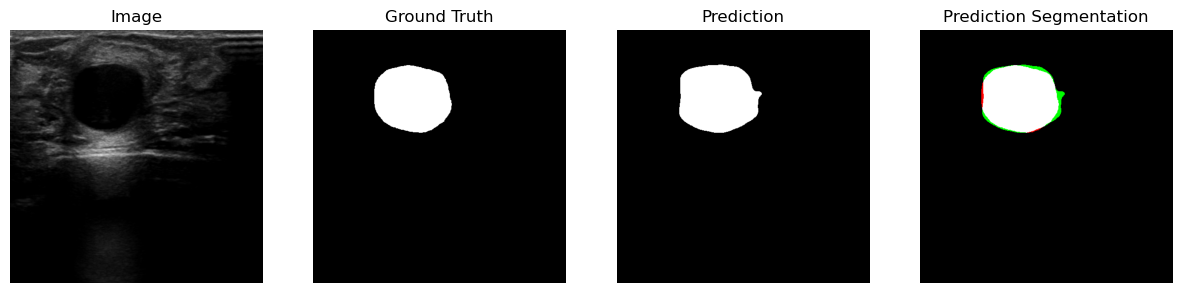

11
Prediction mask was not binary. Applied Otsu threshold: 0.49275147914886475


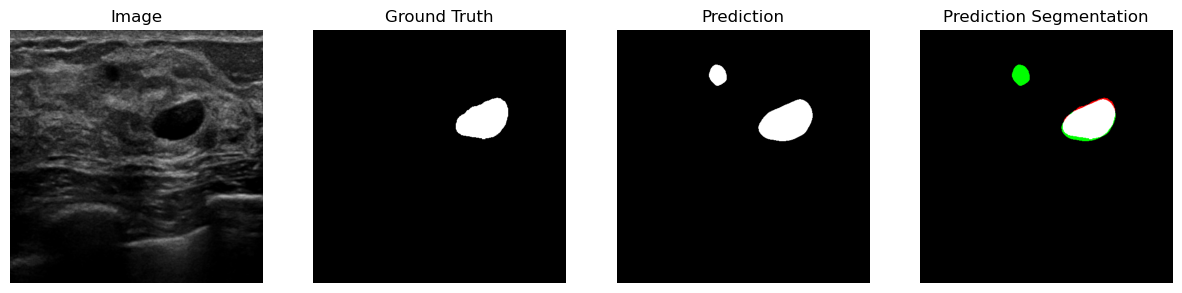

12
Prediction mask was not binary. Applied Otsu threshold: 0.46552425622940063


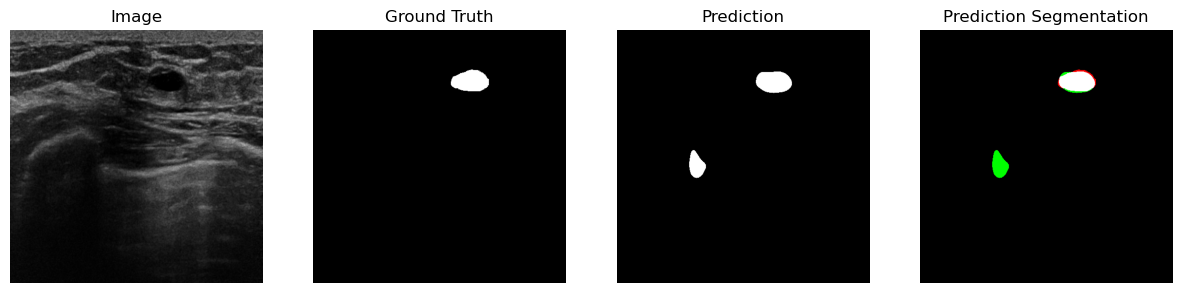

13
Prediction mask was not binary. Applied Otsu threshold: 0.5005987286567688


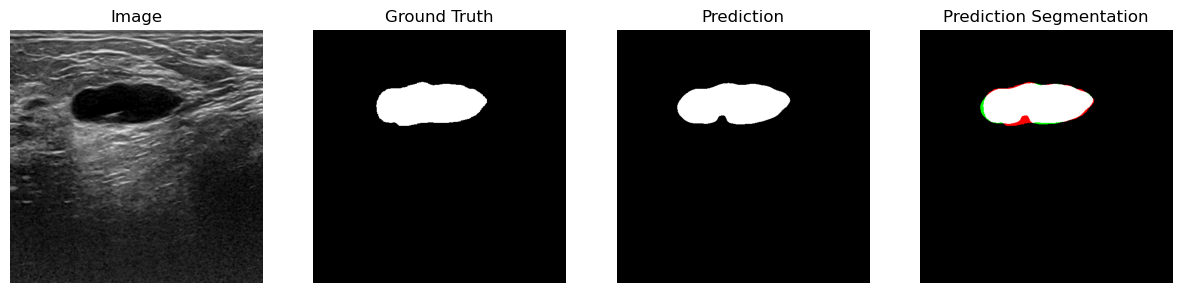

14
Prediction mask was not binary. Applied Otsu threshold: 0.5007450580596924


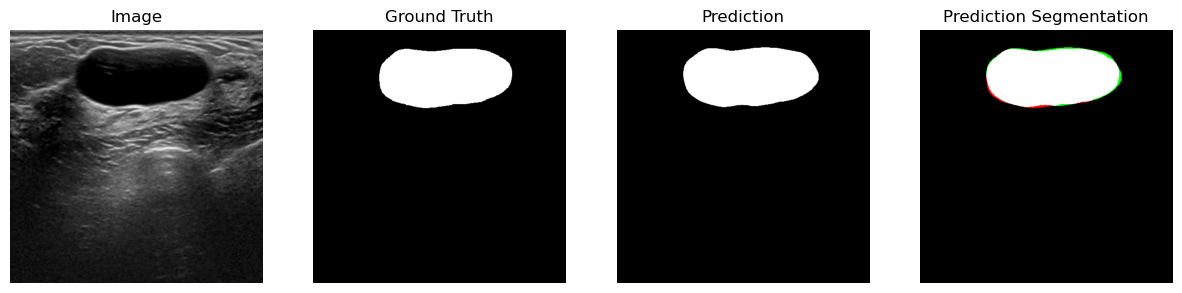

15
Prediction mask was not binary. Applied Otsu threshold: 0.49253666400909424


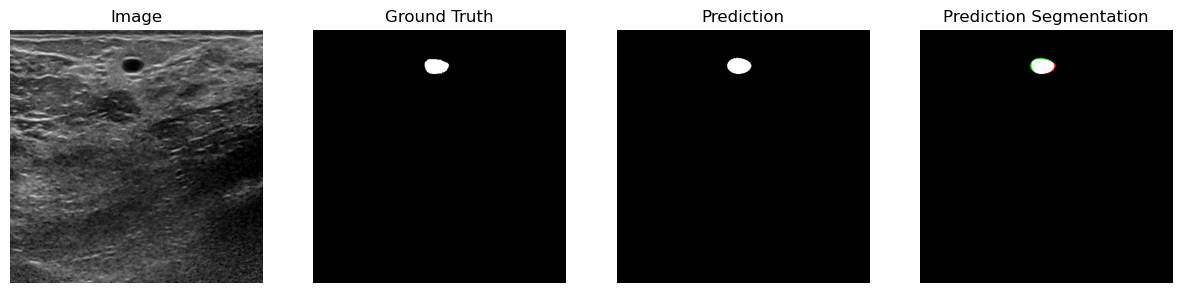

16
Prediction mask was not binary. Applied Otsu threshold: 0.4970054626464844


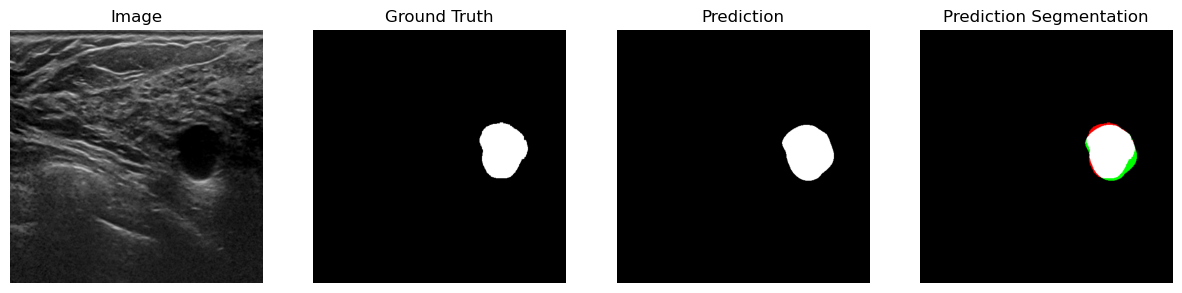

17
Prediction mask was not binary. Applied Otsu threshold: 0.4888511896133423


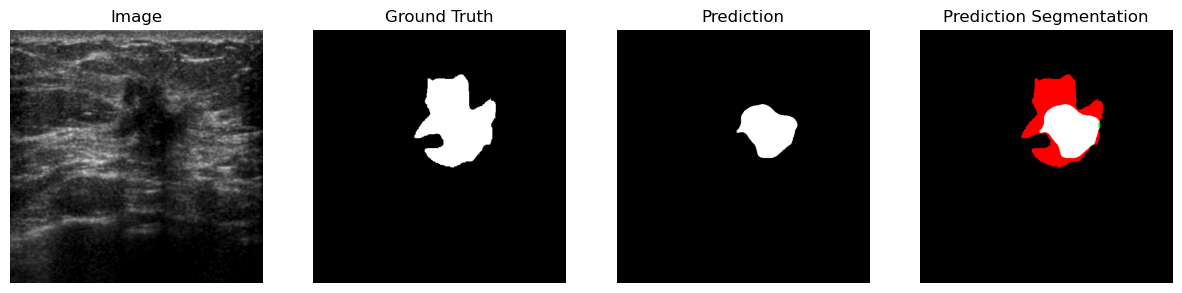

18
Prediction mask was not binary. Applied Otsu threshold: 0.4929783344268799


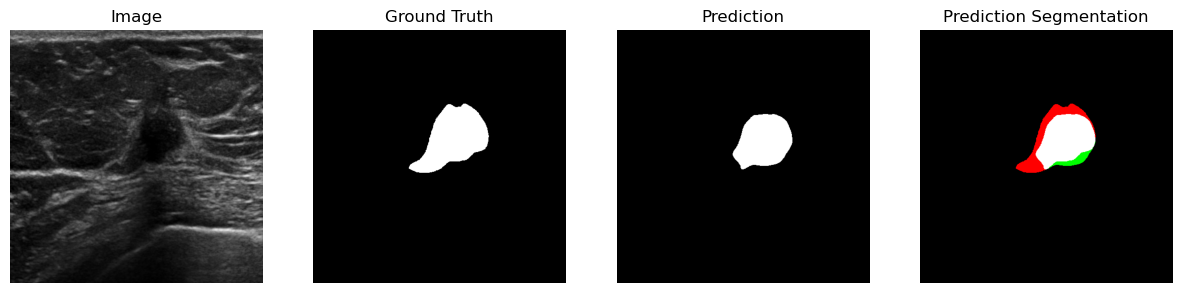

19
Prediction mask was not binary. Applied Otsu threshold: 0.4965885281562805


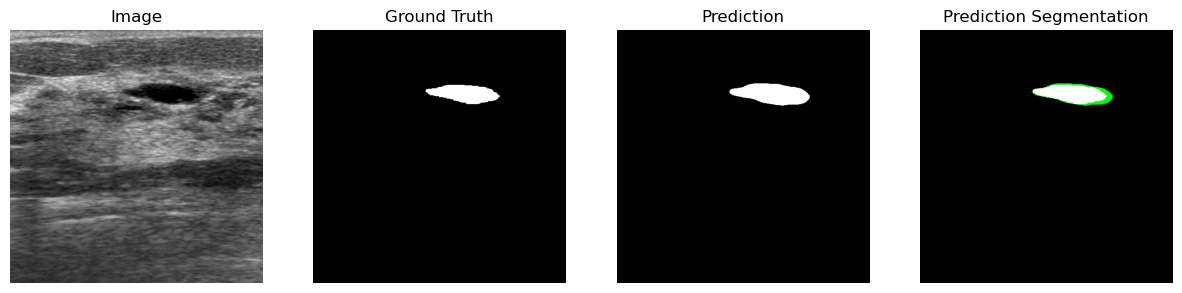

20
Prediction mask was not binary. Applied Otsu threshold: 0.47644728422164917


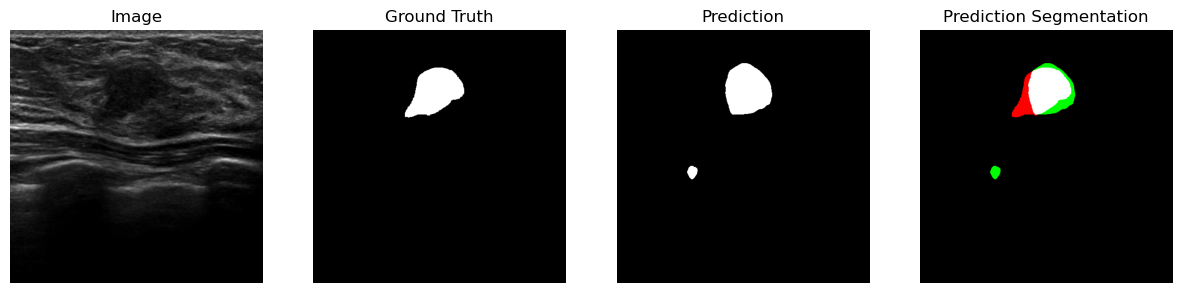

21
Prediction mask was not binary. Applied Otsu threshold: 0.49708181619644165


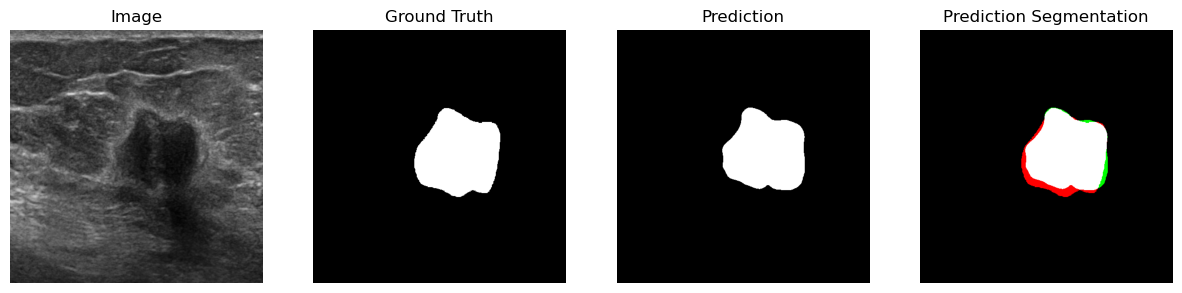

22
Prediction mask was not binary. Applied Otsu threshold: 0.47728246450424194


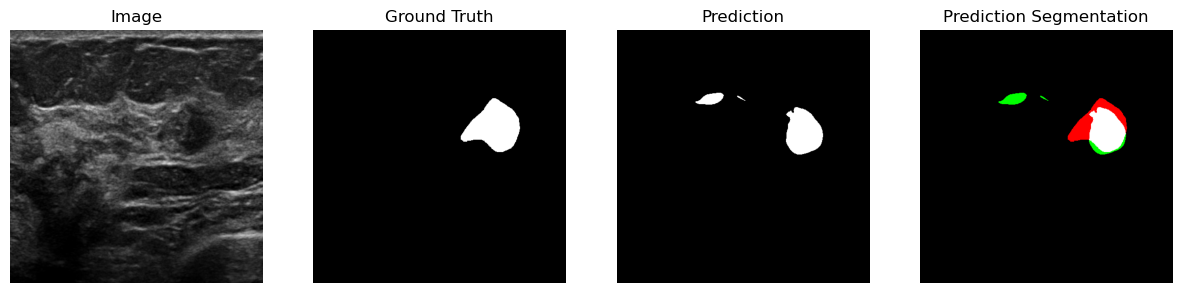

23
Prediction mask was not binary. Applied Otsu threshold: 0.045694947242736816


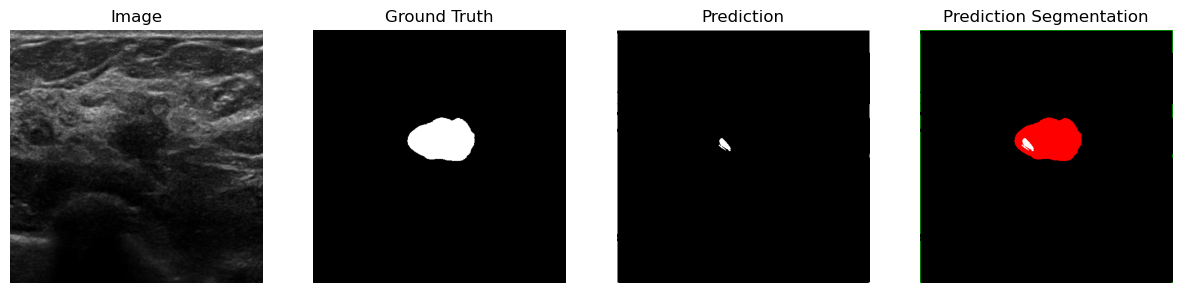

24
Prediction mask was not binary. Applied Otsu threshold: 0.4894557595252991


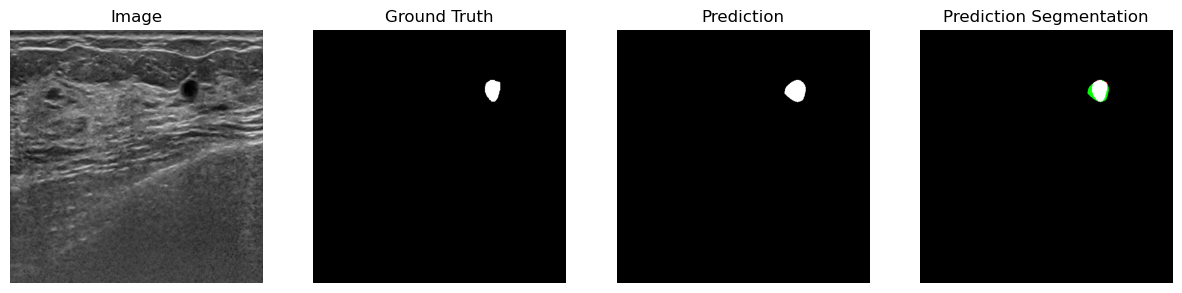

25
Prediction mask was not binary. Applied Otsu threshold: 0.48506802320480347


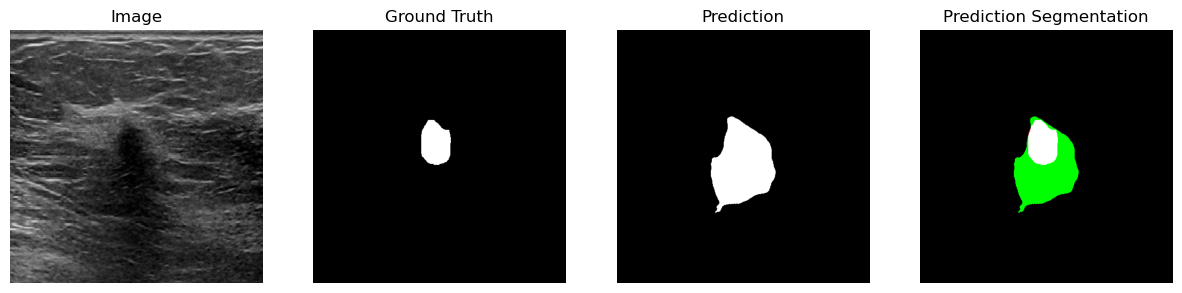

26
Prediction mask was not binary. Applied Otsu threshold: 0.48844242095947266


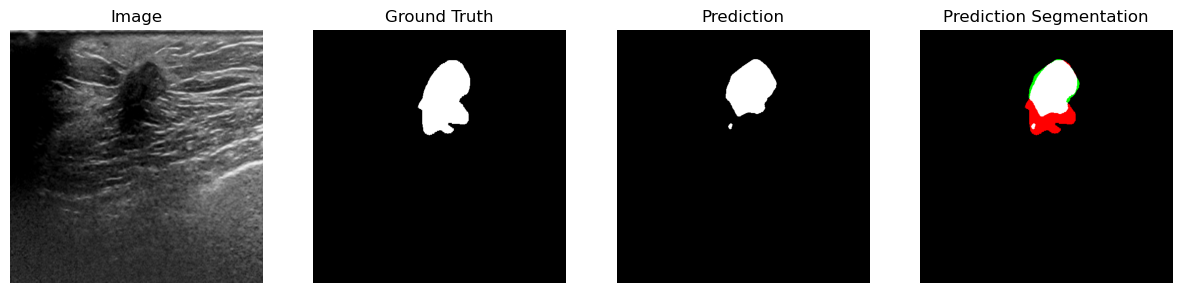

27
Prediction mask was not binary. Applied Otsu threshold: 0.044769302010536194


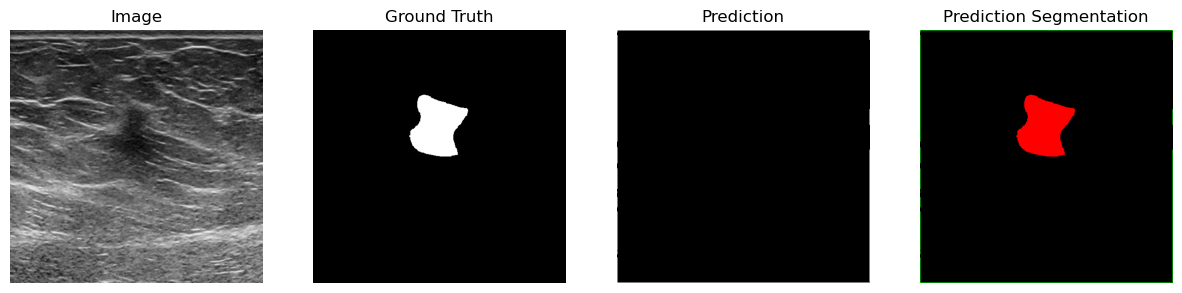

28
Prediction mask was not binary. Applied Otsu threshold: 0.4844118356704712


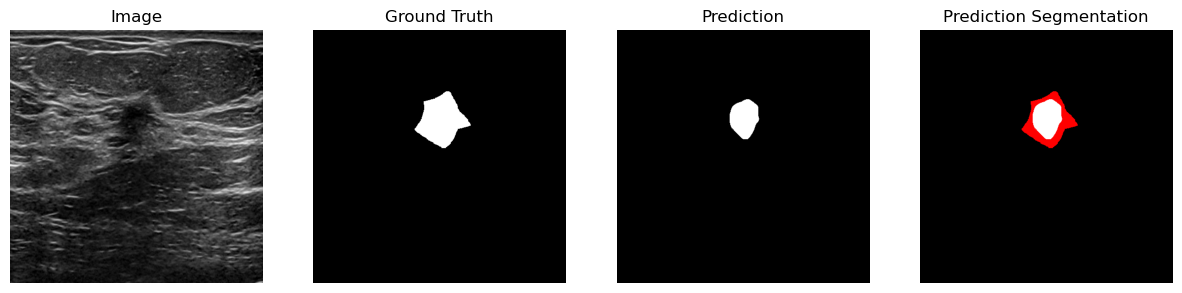

29
Prediction mask was not binary. Applied Otsu threshold: 0.4885278344154358


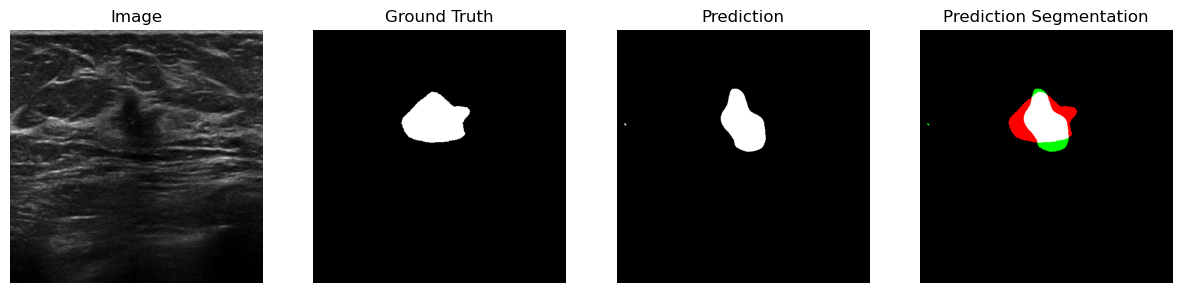

30
Prediction mask was not binary. Applied Otsu threshold: 0.4847384989261627


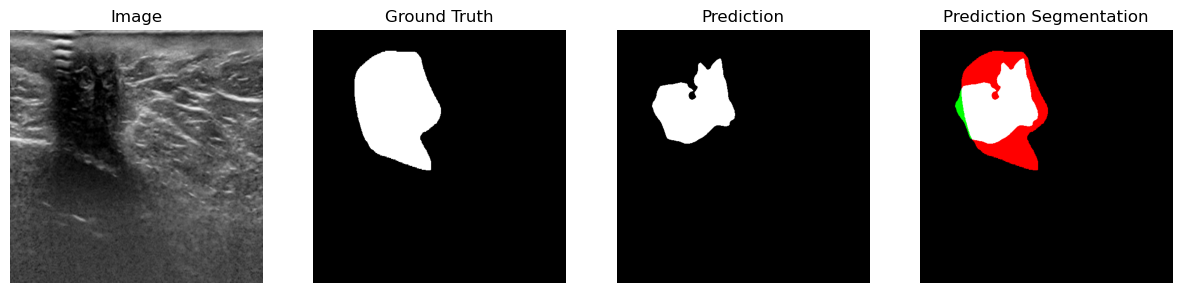

31
Prediction mask was not binary. Applied Otsu threshold: 0.0446016825735569


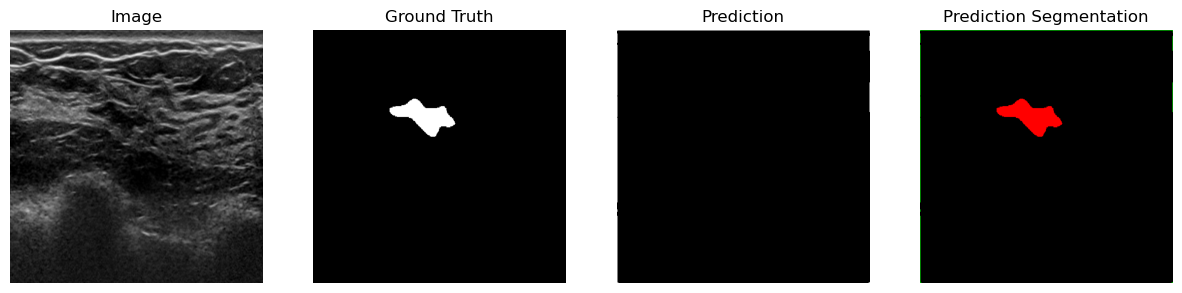

32
Prediction mask was not binary. Applied Otsu threshold: 0.497047483921051


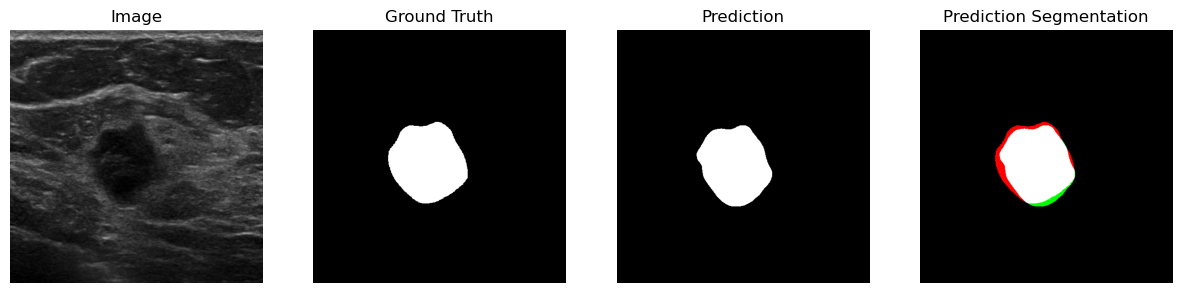

33
Prediction mask was not binary. Applied Otsu threshold: 0.5004769563674927


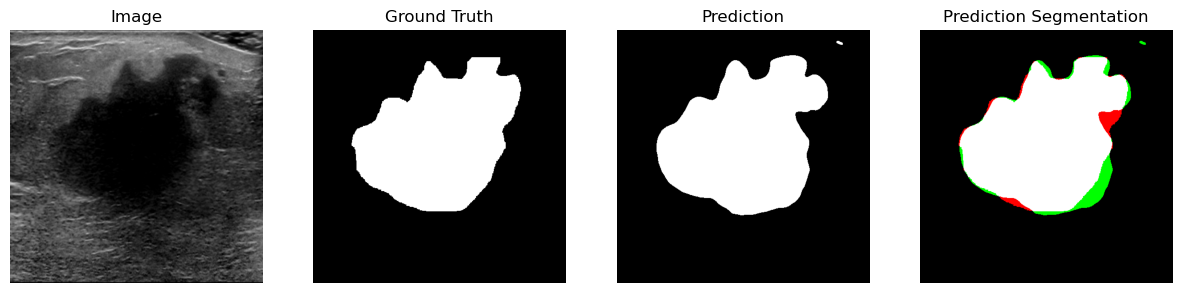

34
Prediction mask was not binary. Applied Otsu threshold: 0.4487733244895935


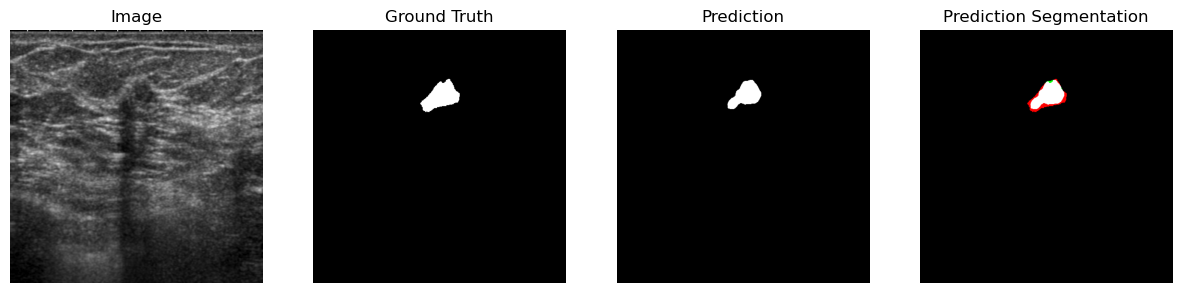

35
Prediction mask was not binary. Applied Otsu threshold: 0.496704638004303


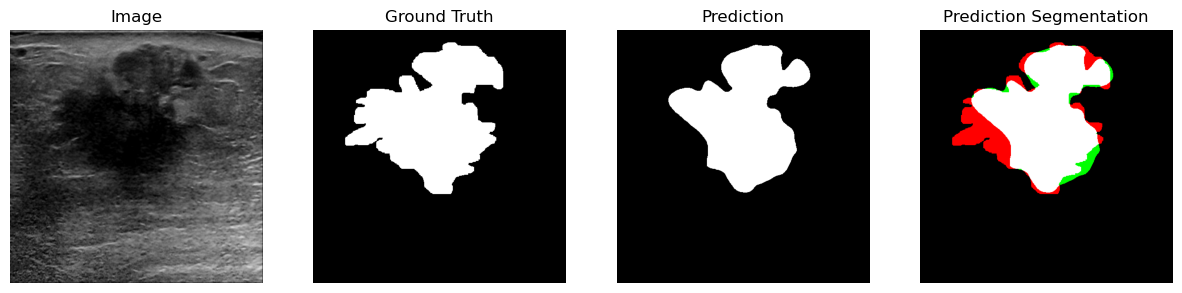

36
Prediction mask was not binary. Applied Otsu threshold: 0.48879092931747437


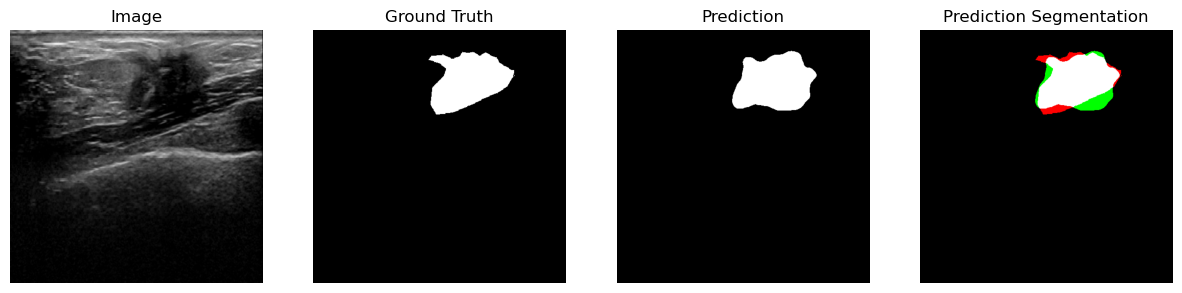

37
Prediction mask was not binary. Applied Otsu threshold: 0.4886854290962219


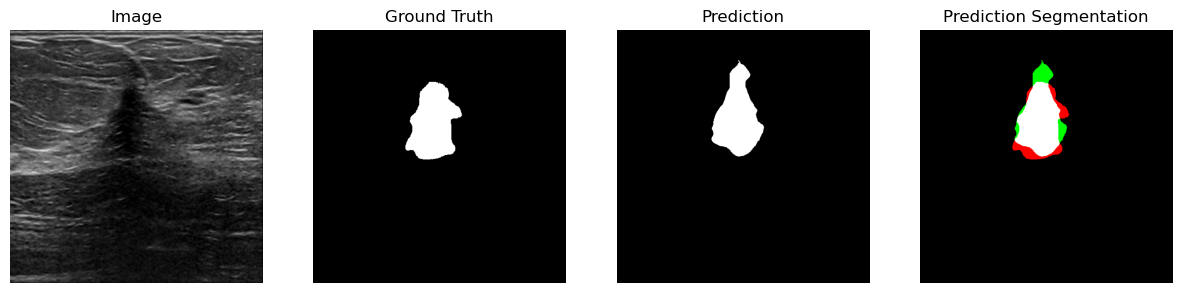

38
Prediction mask was not binary. Applied Otsu threshold: 0.488798588514328


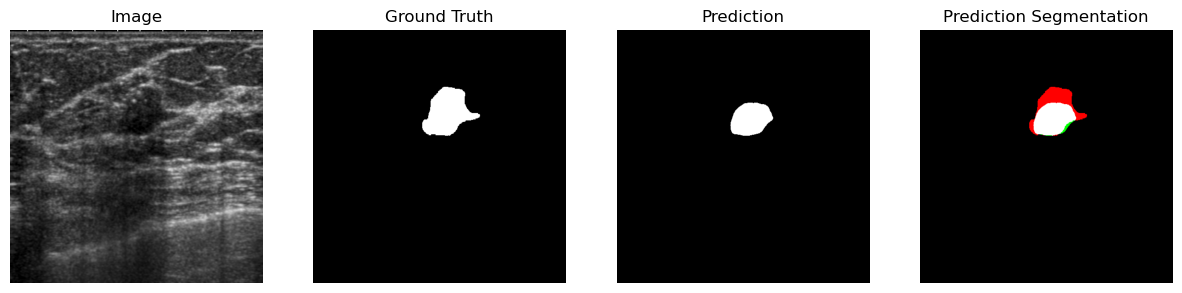

39
Prediction mask was not binary. Applied Otsu threshold: 0.34845441579818726


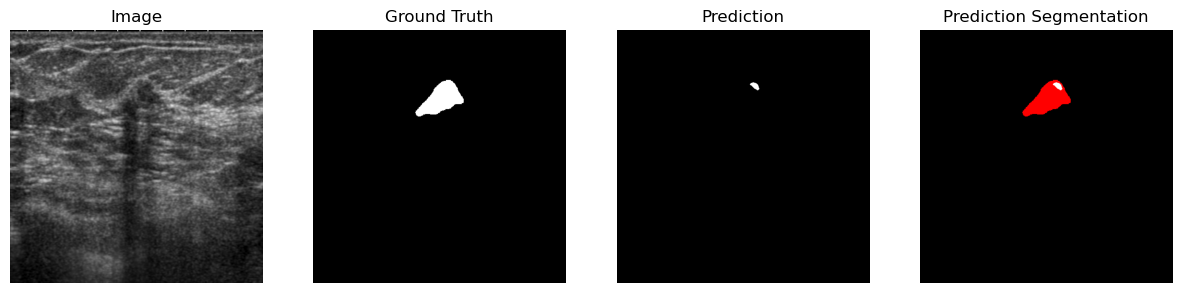

In [215]:
images, masks = next(iter(valid_loader))
with torch.no_grad():
    model2.eval()
    logits = model2(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    # Number of samples visualized
    print(idx)
    if idx <= 40: # change this number!!!
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()
        if isinstance(gt_mask, torch.Tensor):
            gt_mask = gt_mask.cpu().numpy()
        if isinstance(pr_mask, torch.Tensor):
            pr_mask = pr_mask.cpu().numpy()

        if gt_mask.ndim == 3:
            gt_mask = gt_mask.squeeze()
        if pr_mask.ndim == 3:
            pr_mask = pr_mask.squeeze()

        # Check if pr_mask is binary (contains only 0 and 1)
        if not np.all((pr_mask == 0) | (pr_mask == 1)):
            # Apply Otsu's thresholding to make it binary
            thresh = threshold_otsu(pr_mask)
            pr_mask = (pr_mask > thresh).astype(np.uint8)
            print(f"Prediction mask was not binary. Applied Otsu threshold: {thresh}")
        else:
            pr_mask = pr_mask.astype(np.uint8)

        # Ensure masks have the same shape
        assert gt_mask.shape == pr_mask.shape, "Ground truth and prediction masks must have the same shape."

        # Create a color-coded segmentation map
        segmentation_map = np.zeros(gt_mask.shape + (3,), dtype=np.uint8)

        # True Positives (TP): gt_mask == 1 and pr_mask == 1 (White)
        segmentation_map[(gt_mask == 1) & (pr_mask == 1)] = [255, 255, 255]

        # False Positives (FP): gt_mask == 0 and pr_mask == 1 (Green)
        segmentation_map[(gt_mask == 0) & (pr_mask == 1)] = [0, 255, 0]

        # False Negatives (FN): gt_mask == 1 and pr_mask == 0 (Red)
        segmentation_map[(gt_mask == 1) & (pr_mask == 0)] = [255, 0, 0]

        # True Negatives (TN): gt_mask == 0 and pr_mask == 0 (Black)
        segmentation_map[(gt_mask == 0) & (pr_mask == 0)] = [0, 0, 0]

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(image.transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(gt_mask, cmap='gray')  # Display GT as grayscale
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(pr_mask, cmap='gray')
        plt.title("Prediction")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(segmentation_map)
        plt.title("Prediction Segmentation")
        plt.axis("off")

        plt.show()
    else:
        break